# Constructing and Using the CNTK for Image Inpainting/Reconstruction

In this notebook, we provide simple examples of using the CNTK for inpainting/reconstructing high resolution images. 

For image resolutions under 256 x 256 and for networks with at most 5 layers of downsampling/upsampling, it is feasible to perform all the computation on the CPU.  All computation for constructing the kernel is on the CPU and parallelized across CPU threads.  

For simplicity, we make the following assumptions about the neural networks used: 

1. The first layer is a convolutional layer.  
2. Each convolutional layer is followed by a nonlinearity.  For this library, we have implemented the dual activation functions for ReLU and LeakyReLU.  

We have tried to match the notation from PyTorch as much as possible for constructing neural network architectures.  The available layers are Convolutional, ReLU, LeakyReLU, Downsample, and Upsample.  

## Overview of Kernel Regression with the CNTK 

#### This section is a high level overview describing our method.  It is primarily for those without a background in kernel regression. 

Before showcasing the CNTK for image inpainting, we provide an overview of what it means to use the CNTK for image inpainting.  Let us suppose we are first given an image of resolution $256 \times 256$ that is corrupted as follows.  

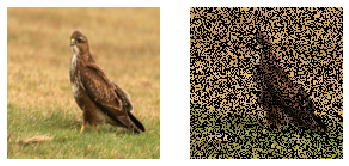

In [1]:
import utilities.load_image as loader

fname = 'data/bird.jpg'
clean, corrupted, mask = loader.load_image(fname)
loader.visualize_corrupted_image(clean, corrupted)

### Imputing Missing Entries as a Linear Combination of Other Entries

Our goal is to recover the clean image given only the corrupted one shown on the right.  To do this, we will write each missing pixel as a linear combination of all observed pixels in the image.  

How do we select the coeffificents used in the linear combinations? Well, we will select these coefficients by constructing a four dimensional array, $K$, of size $256 \times 256 \times 256 \times 256$ that has the following property.

Entry $(i,j, i', j')$ of this array should indicate similarity between the pixels at coordinate $(i,j)$ and $(i',j')$ in the image.  For example, we would expect $K(1, 1, 1, 2)$ to be much larger than $K(1, 1, 128, 128)$ since coordinates $(1,1)$ and $(1,2)$ are much closer to each other than $(1, 1)$ and $(128, 128)$.  

Our method will automatically construct an array $K$ that satisifies the property above.

### Using the CNTK to Compute the Coefficients of this Linear Combination

Once we have the array $K$ from the CNTK, how do we actually use it to fill in the missing pixels in the image above?  

We will first reshape $K$ to be a matrix of size $256^2 \times 256^2$.  As not all pixels are observed in the image, we need to remove all rows and columns of $K$ that correspond to coordinates where a pixel is missing.  Let us call the remaining matrix $K_{train}$.  For example, if we assume that exactly half the pixels in the image above are discarded, then $K_{train}$ is of size $128^2 \times 128^2$.  

Recall that every entry $(a,b)$ in $K_{train}$ actually corresponds to a entry for pair of pixel coordinates $(a_i, a_j), (b_i, b_j)$ in the original four dimensional array.  For each row $a$ of $K_{train}$, let us also associate a value $y_{a}$, which is just the value of the observed pixel at coordinate $(a_i, a_j)$ in the image.  We will thus have $128^2$ values $\{y_{a}\}$, which we can concatenate into a vector $y$.  

We will then solve the following linear system for the vector $w$:  $$ K_{train} w = y \implies w = K_{train}^{-1} y$$

To finally compute the value for a missing pixel, we just select the column, $k$, in $K$ corresponding to the missing pixel and then just compute: $$ k w = k K_{train}^{-1} y$$

While simple, our work shows that the above procedure performs remarkably well.  In this notebook, we walk through the full computation for the above example.   

## Our API for Constructing the CNTK given an Neural Network Architecture
Below we begin with an example of constructing the CNTK for a 16 x 16 image for the following simple architecture:

In [2]:
import construct_kernel.layers as nn

# Construct a network for which we will compute the CNTK 
net = nn.Sequential(nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Downsample(),
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),                    
                    nn.Downsample(),
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Downsample(),      
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Upsample(bilinear=False),                    
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Upsample(bilinear=False),
                    nn.Conv(kernel_size=3),
                    nn.LeakyReLU(),
                    nn.Upsample(bilinear=False),
                    nn.Conv(kernel_size=3))

Just like in PyTorch, you can specify the filter size (i.e. "kernel_size") for convolutional layers, and you can specify whether the upsampling layer should be bilinear or nearest neighbor upsampling.  

Next, we will get the NTK for the above architecture.  This is done using the "get_ntk" function.  This function takes in an image size, $d$, a number of CPU threads to parallel computation over, and optionally takes in a feature prior $X \in \mathbb{R}^{c \times d \times d}$ (by default, the prior is assumed to correspond to a stationary distribution).  

In [3]:
# Provide an image size, number of CPU threads, and possibly a feature prior X for computing the kernel 
image_size = 16
K = net.get_ntk(image_size, num_threads=16)

100%|██████████| 19/19 [00:01<00:00, 11.73it/s]


If we look at the shape of $K$ computed above, we see that it is of size $16 \times 16 \times 16 \times 16$.  This is exactly the four dimensional array that we will index for imputing missing pixel values.  

In [4]:
print(K.shape)

(16, 16, 16, 16)


## Filling in Missing Pixel Values with the CNTK 

We will now use the kernel, $K$, computed above to fill in pixel values in our missing image. 

Loaded and Expanded Kernel; Now Subsetting Observed Entries
Starting exact solve for kernel regression
This system has 8127 equations & unknowns.
3.769845962524414  time for solve
(3, 8257)


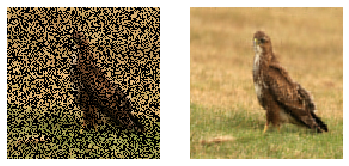

In [5]:
import kr_solvers.expand_and_solve as exact_solver

exact_solver.fill_image(K, net, corrupted, mask)